In [1]:
import numpy as np
import pandas as pd

## Creating sine dataframe here!

# Define time vector (e.g., from 0 to 10 seconds, with 1000 points)
time = np.linspace(0, 10, 1000)

# Define sine wave parameters
frequency = 1.5  # Hz (change this to adjust the wave frequency)
amplitude = 2.3547  # unitless (change this to adjust the wave amplitude)

# Generate sine wave values
sine_wave = amplitude * np.sin(2 * np.pi * frequency * time)

# Create DataFrame
sine_df = pd.DataFrame({
    'Time (seconds)': time,
    'Sine Amplitude': sine_wave
})

# Show the first few rows
print(sine_df.head())


   Time (seconds)  Sine Amplitude
0         0.00000        0.000000
1         0.01001        0.221818
2         0.02002        0.441663
3         0.03003        0.657580
4         0.04004        0.867649


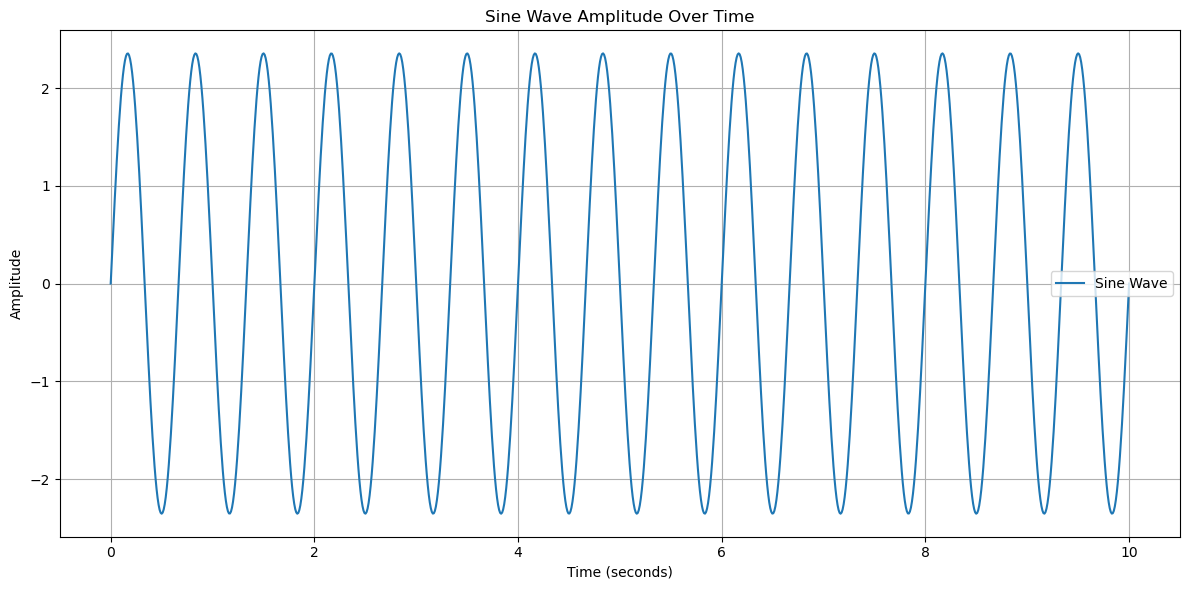

In [2]:
## This is my sine wave data plot

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(sine_df['Time (seconds)'], sine_df['Sine Amplitude'], label='Sine Wave')
plt.title('Sine Wave Amplitude Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# ---- Step 1: Generate Sine Wave ----
def generate_sine_wave(frequency=1.5, amplitude=2.3547, duration=10, points=1000):
    time = np.linspace(0, duration, points)
    sine_wave = amplitude * np.sin(2 * np.pi * frequency * time)
    return pd.DataFrame({'Time (seconds)': time, 'Sine Amplitude': sine_wave})

sine_df = generate_sine_wave()

# ---- Step 2: Scale Amplitude to [0, 1] ----
def normalize_series(series):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(series.reshape(-1, 1))
    return scaled, scaler

amplitudes_scaled, scaler = normalize_series(sine_df["Sine Amplitude"].values)

# ---- Step 3: Create Sequences for Seq2Seq Model ----
def create_sequences(data, input_steps=30, output_steps=50):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps):
        X.append(data[i:i + input_steps])
        y.append(data[i + input_steps:i + input_steps + output_steps])
    return np.array(X), np.array(y)

input_steps = 30
output_steps = 50
X_seq, y_seq = create_sequences(amplitudes_scaled, input_steps, output_steps)

# Reshape to (samples, timesteps, features)
X_seq = X_seq.reshape(-1, input_steps, 1)
y_seq = y_seq.reshape(-1, output_steps, 1)

# ---- Step 4: Train/Validation Split ----
def train_val_split(X, y, split_ratio=0.8):
    split_index = int(len(X) * split_ratio)
    return X[:split_index], y[:split_index], X[split_index:], y[split_index:]

X_train, y_train, X_val, y_val = train_val_split(X_seq, y_seq)

# ✅ Now you can use X_train, y_train, X_val, y_val in model.fit()


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np

# --------------------------
# Positional Encoding
# --------------------------
class PositionalEncoding(layers.Layer):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.pos_encoding = self._get_pos_encoding(max_len, d_model)

    def _get_pos_encoding(self, max_len, d_model):
        pos = np.arange(max_len)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rates = pos / np.power(10000, (2 * (i // 2)) / np.float32(d_model))

        angle_rates[:, 0::2] = np.sin(angle_rates[:, 0::2])
        angle_rates[:, 1::2] = np.cos(angle_rates[:, 1::2])
        pos_encoding = angle_rates[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

# --------------------------
# Causal Mask for Decoder
# --------------------------
def create_causal_mask(seq_len):
    return tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)

# --------------------------
# Transformer Decoder Block
# --------------------------
def decoder_block(x, enc_output, causal_mask, head_size=64, num_heads=2, ff_dim=128, dropout=0.1):
    # Self-attention with causal mask
    x1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(x, x, attention_mask=causal_mask)
    x1 = layers.Dropout(dropout)(x1)
    x = layers.LayerNormalization(epsilon=1e-6)(x + x1)

    # Cross-attention with encoder output
    x2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(x, enc_output)
    x2 = layers.Dropout(dropout)(x2)
    x = layers.LayerNormalization(epsilon=1e-6)(x + x2)

    # Feedforward
    ff = layers.Dense(ff_dim, activation='relu')(x)
    ff = layers.Dense(head_size)(ff)
    x = layers.Dropout(dropout)(ff)
    return layers.LayerNormalization(epsilon=1e-6)(x + ff)

# --------------------------
# Build Model
# --------------------------
def build_transformer(input_steps=30, output_steps=50, input_dim=1, d_model=64, num_layers=2):
    # Encoder
    encoder_inputs = layers.Input(shape=(input_steps, input_dim))
    x_enc = layers.Dense(d_model)(encoder_inputs)
    x_enc = PositionalEncoding(input_steps, d_model)(x_enc)
    for _ in range(num_layers):
        x_enc = decoder_block(x_enc, x_enc, None, head_size=d_model)  # self-attn only

    # Decoder
    decoder_inputs = layers.Input(shape=(output_steps, input_dim))
    x_dec = layers.Dense(d_model)(decoder_inputs)
    x_dec = PositionalEncoding(output_steps, d_model)(x_dec)

    # Create causal mask
    causal_mask = create_causal_mask(output_steps)

    for _ in range(num_layers):
        x_dec = decoder_block(x_dec, x_enc, causal_mask, head_size=d_model)

    outputs = layers.TimeDistributed(layers.Dense(input_dim))(x_dec)
    model = Model([encoder_inputs, decoder_inputs], outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_transformer()
model.summary()


2025-06-11 15:37:17.483768: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-11 15:37:17.486313: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-11 15:37:17.527104: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-11 15:37:17.528494: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-11 15:37:18.231423: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30, 1)]              0         []                            
                                                                                                  
 dense (Dense)               (None, 30, 64)               128       ['input_1[0][0]']             
                                                                                                  
 positional_encoding (Posit  (None, 30, 64)               0         ['dense[0][0]']               
 ionalEncoding)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 30, 64)               33216     ['positional_encoding[0][0

In [ ]:
# def autoregressive_predict(model, input_seq, output_steps, input_dim=1):
#     input_seq = np.expand_dims(input_seq, axis=0)  # batch dimension
#     dec_input = np.zeros((1, 1, input_dim))  # Start with zero

#     outputs = []
#     for _ in range(output_steps):
#         pred = model.predict([input_seq, dec_input], verbose=0)
#         next_val = pred[:, -1:, :]  # last predicted step
#         outputs.append(next_val)
#         dec_input = np.concatenate([dec_input, next_val], axis=1)

#     return np.concatenate(outputs, axis=1).squeeze()


In [6]:
## Training the model
import numpy as np
# Assume model is built with build_transformer(...)
model = build_transformer(input_steps, output_steps)

# Prepare decoder input (zero vector of shape (batch, output_steps, 1))
decoder_input_train = np.zeros_like(y_train)
decoder_input_val = np.zeros_like(y_val)

history = model.fit(
    [X_train, decoder_input_train], y_train,
    validation_data=([X_val, decoder_input_val], y_val),
    epochs=20,
    batch_size=64
)



Epoch 1/20
12/12 [==============================] - 7s 36ms/step - loss: 1.2816 - val_loss: 0.2203
Epoch 2/20
12/12 [==============================] - 2s 145ms/step - loss: 0.2692 - val_loss: 0.1286
Epoch 3/20
12/12 [==============================] - 2s 185ms/step - loss: 0.1908 - val_loss: 0.1410
Epoch 4/20
12/12 [==============================] - 2s 206ms/step - loss: 0.1777 - val_loss: 0.1280
Epoch 5/20
12/12 [==============================] - 2s 178ms/step - loss: 0.1707 - val_loss: 0.1266
Epoch 6/20
12/12 [==============================] - 2s 177ms/step - loss: 0.1670 - val_loss: 0.1266
Epoch 7/20
12/12 [==============================] - 2s 176ms/step - loss: 0.1636 - val_loss: 0.1266
Epoch 8/20
12/12 [==============================] - 2s 175ms/step - loss: 0.1599 - val_loss: 0.1265
Epoch 9/20
12/12 [==============================] - 2s 170ms/step - loss: 0.1573 - val_loss: 0.1263
Epoch 10/20
12/12 [==============================] - 2s 178ms/step - loss: 0.1532 - val_loss: 0.1264


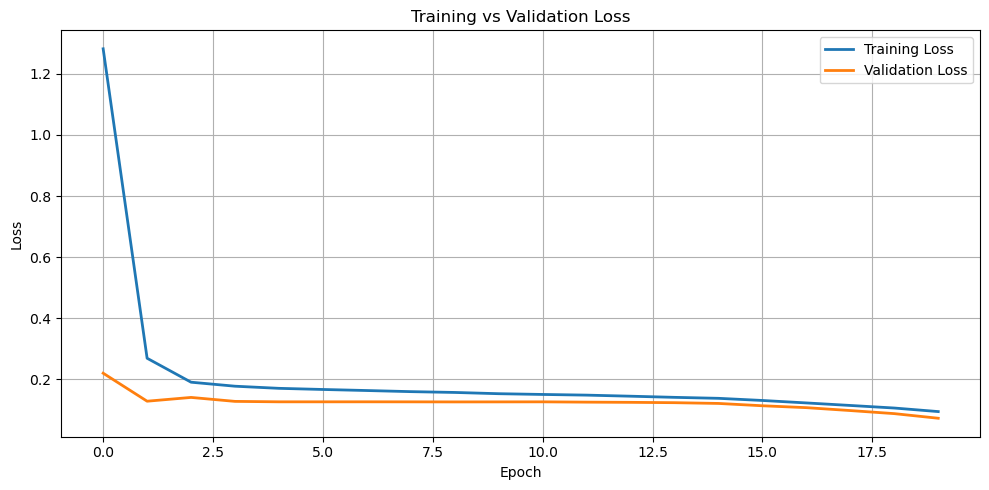

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 489ms/step


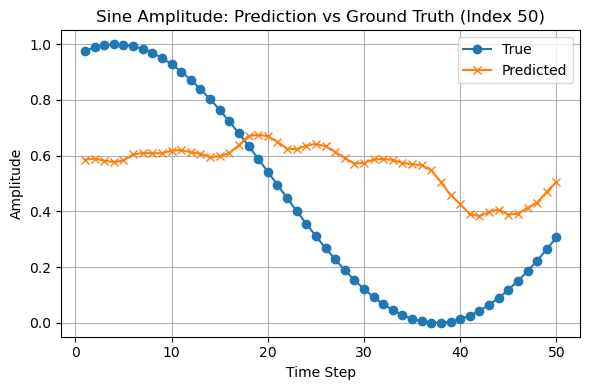

1/1 [==============================] - 0s 39ms/step


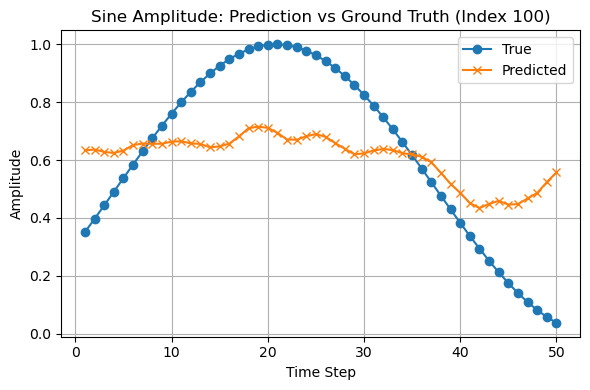

1/1 [==============================] - 0s 29ms/step


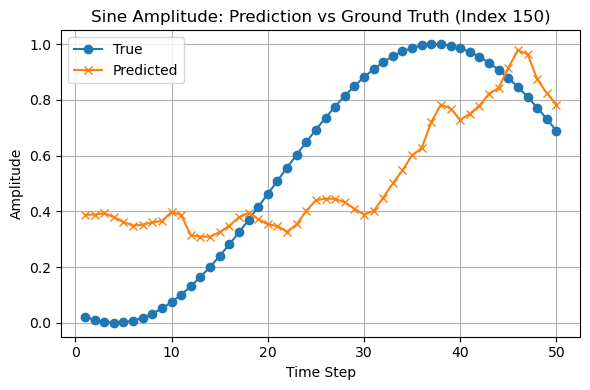

1/1 [==============================] - 0s 40ms/step


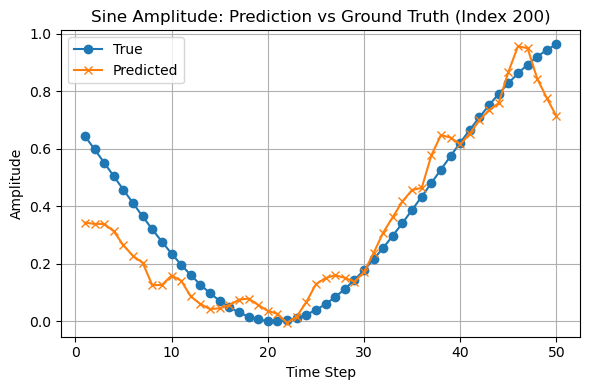

1/1 [==============================] - 0s 33ms/step


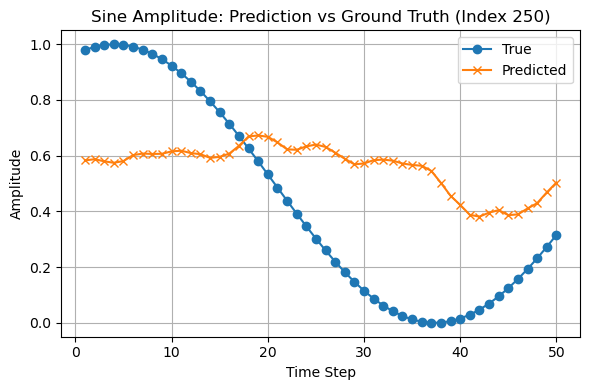

In [9]:
import matplotlib.pyplot as plt
import numpy as np

for i in [50, 100, 150, 200, 250]:
    index = i
    encoder_input = X_seq[index:index+1]                    # (1, 30, 1)
    decoder_input = np.zeros((1, y_seq.shape[1], 1))        # (1, 50, 1)
    
    pred = model.predict([encoder_input, decoder_input])    # (1, 50, 1)
    true = y_seq[index]                                     # (50, 1)

    time_steps = np.arange(1, 51)
    plt.figure(figsize=(6, 4))
    plt.plot(time_steps, true, label='True', marker='o')
    plt.plot(time_steps, pred[0, :, 0], label='Predicted', marker='x')
    plt.title(f'Sine Amplitude: Prediction vs Ground Truth (Index {index})')
    plt.xlabel('Time Step')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


29/29 [==============================] - 1s 30ms/step


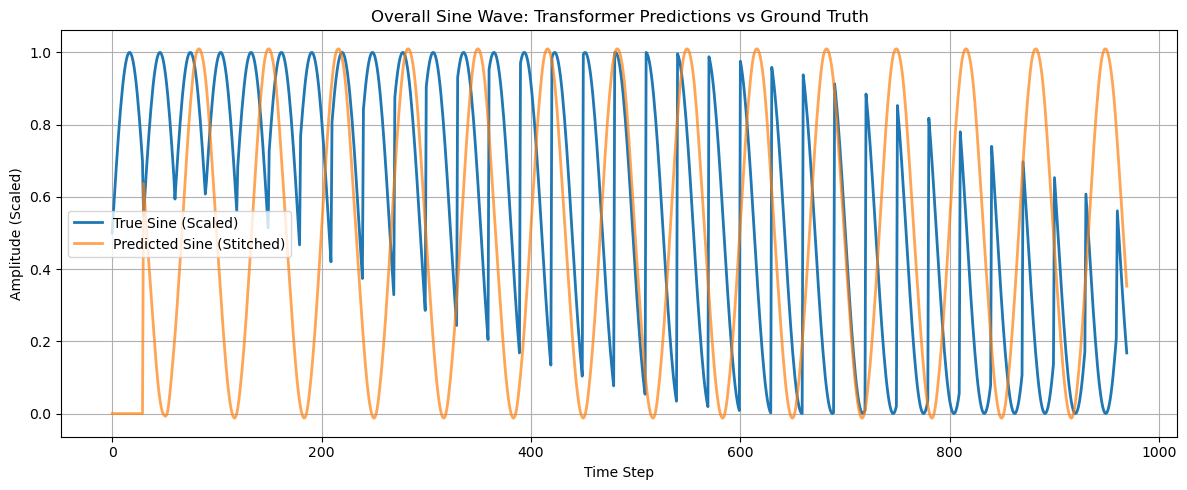

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Predict all sequences
# all_preds = TransformerModel.predict(X_seq).squeeze()  # shape: (num_samples, 50)

# # Prepare buffers
# total_length = len(X_seq) + output_steps
# reconstructed_sum = np.zeros(total_length)
# reconstructed_count = np.zeros(total_length)

# # Stitch predictions
# for i in range(len(X_seq)):
#     start = i + input_steps
#     end = start + output_steps
#     end = min(end, total_length)  # <-- prevent overstepping
#     pred_slice = all_preds[i, :end-start]
#     reconstructed_sum[start:end] += pred_slice
#     reconstructed_count[start:end] += 1

# # Average overlapping predictions
# reconstructed = np.zeros_like(reconstructed_sum)
# mask = reconstructed_count > 0
# reconstructed[mask] = reconstructed_sum[mask] / reconstructed_count[mask]

# # True signal (flattened from input and output)
# true_series = np.concatenate((X_seq[:, :, 0].flatten(), y_seq[-1, :, 0]))
# true_series = true_series[:len(reconstructed)]  # ensure same length

# # Plot
# plt.figure(figsize=(12, 5))
# plt.plot(true_series, label="True Sine (Scaled)", linewidth=2)
# plt.plot(reconstructed, label="Predicted Sine (Stitched)", linewidth=2, alpha=0.7)
# plt.title("Overall Sine Wave: Transformer Predictions vs Ground Truth")
# plt.xlabel("Time Step")
# plt.ylabel("Amplitude (Scaled)")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


## Appendix 

In [ ]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# ## LSTM ENCODER-DECODER MODEL

# # ------------------------
# # Model Configuration
# # ------------------------

# input_steps = 30      # Number of time steps in the input sequence
# output_steps = 50     # Number of time steps to predict
# input_dim = 1         # Number of features per time step (e.g., just sine amplitude)

# # ------------------------
# # Encoder
# # ------------------------

# # Define input shape: a sequence of 30 time steps, each with 1 feature - the sine amplitude
# # This will be the input to the encoder
# encoder_inputs = Input(shape=(input_steps, input_dim))  # shape: (None, 30, 1)

# # LSTM processes the sequence and outputs a single latent vector (size 64)
# encoder_lstm = LSTM(64, return_sequences=False)(encoder_inputs)  # shape: (None, 64)

# ## -------------------------------------
# ## Right now I have a long vector of 64 features but my decoder expects a sequence of 50 time steps.
# ##

# # ------------------------
# # Decoder
# # ------------------------

# # Repeat the latent vector 50 times to prepare for decoder input
# # shape becomes (None, 50, 64)
# decoder_repeated = RepeatVector(output_steps)(encoder_lstm)

# # LSTM processes the repeated context and returns a full sequence of 50 steps
# # Each step still has 64 features internally
# decoder_lstm = LSTM(64, return_sequences=True)(decoder_repeated)  # shape: (None, 50, 64)

# # Apply a Dense layer to each of the 50 time steps to predict 1 value per step
# # Final output shape: (None, 50, 1)
# decoder_outputs = Dense(input_dim)(decoder_lstm)

# # ------------------------
# # Define and Compile Model
# # ------------------------

# # Build the full model from encoder input to decoder output
# LSTMmodel = Model(inputs=encoder_inputs, outputs=decoder_outputs)

# # Compile using Mean Squared Error loss, standard for regression
# LSTMmodel.compile(optimizer='adam', loss='mse')

# # Print summary of architecture
# LSTMmodel.summary()